# Baseline analysis for predicting next day's Covid-19 cases from prior 30

In [167]:
import os
import importlib
import random
from collections import defaultdict
import math

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


import dsci592.model as model

In [168]:
importlib.reload(model)

<module 'dsci592.model' from '/home/noah/projects/drexel/dsci592/DS-capstone-pt1/code/src/dsci592/model.py'>

In [3]:
pd.set_option("display.max_columns", None)
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [4]:
golden_dataset_file_name = os.path.join('/', 'data', 'projects', 'drexel', 'dsci592', 'feeFiFoFum.pkl')
with tf.device('/gpu:1'):  # using other GPU for another task
    df = model.load_dataset(golden_dataset_file_name)

# train_ds, val_ds, test_ds = model.get_train_test_eval_ds()


2022-02-20 15:27:50.415299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 15:27:50.415531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 15:27:50.444235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 15:27:50.444469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 15:27:50.444671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [8]:
def get_new_loop():
    train_ds, val_ds, test_ds = model.get_train_test_eval_ds()
    return ('train', train_ds), ('validate', val_ds), ('test', test_ds)
    

## Baseline 1: Guess zero every time

In [20]:
for name, ds in get_new_loop():
    sum = count = 0
    for _, y in ds:
        y_ = y.numpy().flatten()
        sum += y_.sum()
        count += y_.shape[0]
    print(f'{name}: {sum/count}')


train: 1738.2500355774011
validate: 1754.9772079984493
test: 1739.3318410911274


## Baseline 2: Guess the 30th date every time

In [51]:
for name, ds in get_new_loop():
    errors = count = 0
    for x, y in ds:
        y_ = y.numpy().flatten()        
        x_ = x.numpy()[:,-1:,:1].flatten()
        errors += np.sum(np.abs(y_ - x_))
        count += y_.shape[0]
    print(f'{name}: {errors/count}')


train: 9.785121290955985
validate: 9.549475865976769
test: 9.840210704599464


## Baseline 3: Guess the mean of the 30 days every time

In [63]:
for name, ds in get_new_loop():
    errors = count = 0
    for x, y in ds:
        y_ = y.numpy().flatten()        
        x_ = x.numpy()[:,:,:1]
        x_ = np.mean(x_, axis=1).flatten()
        errors += np.sum(np.abs(y_ - x_))
        count += y_.shape[0]
    print(f'{name}: {errors/count}')


train: 121.31485035080716
validate: 120.17304839525893
test: 120.88257879796626


## Baseline 4: Linear regression

In [116]:
for name, ds in get_new_loop():
    errors = count = 0
    lr = LinearRegression()
    for x, y in ds:
        y_ = y.numpy().flatten()        
        x_ = x.numpy()[:,:,:1]
        days = x_.shape[1]
        z = np.arange(days).reshape(-1,1)
        next_date = np.array([days + 1]).reshape(-1,1)
        for i in range(x_.shape[0]):
            lr.fit(z,x_[i])
            errors += np.abs(y[i] - lr.predict(next_date)[0][0])
            count += 1
    print(f'{name}: {errors[0][0]/count}')


train: [[36.93661786]]
validate: [[36.07154467]]
test: [[36.6260068]]


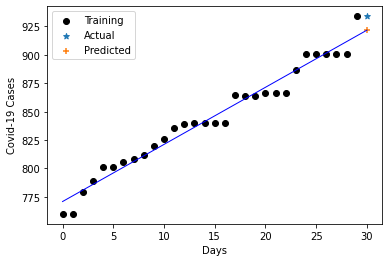

In [142]:
z = np.arange(days).reshape(-1,1)
plt.scatter(z, x_[i], color="black", label='Training')
z_ = np.arange(days+1).reshape(-1,1)
plt.plot(z_, lr.predict(z_), color="blue", linewidth=1)
plt.scatter(30, y_[i], marker='*', label='Actual')
plt.scatter(30, lr.predict(z_)[-1], marker='+', label='Predicted')
plt.ylabel('Covid-19 Cases')
plt.xlabel('Days')
plt.legend()
# plt.xticks(())
# plt.yticks(())
plt.savefig('linear_regression_example.png')
_ = plt.show()


# Baseline analysis for predicting next seven day's Covid-19 cases from prior 30

In [175]:
# train_ds, val_ds, test_ds = model.get_train_test_eval_ds(train='./data/train7/x_*.npy', test='./data/test7/x_*.npy', eval_='./data/eval7/x_*.npy', days_to_predict=7)

DAYS_TO_PREDICT=7

def get_new_loop():
    train_ds, val_ds, test_ds = model.get_train_test_eval_ds(train='./data/train7/x_*.npy', test='./data/test7/x_*.npy', eval_='./data/eval7/x_*.npy', days_to_predict=DAYS_TO_PREDICT)
    return ('train', train_ds), ('validate', val_ds), ('test', test_ds)

In [176]:
class NestedDefaultDict(defaultdict):
    def __init__(self, *args, **kwargs):
        super(NestedDefaultDict, self).__init__(NestedDefaultDict, *args, **kwargs)

    def __repr__(self):
        return repr(dict(self))

summary_results = NestedDefaultDict()

def save_summary_results(baseline, dataset, day, mae, rmse):
    summary_results[baseline][dataset][day]['mae'] = mae
    summary_results[baseline][dataset][day]['rmse'] = rmse
    

## Baseline 1: Guess zero every time

In [177]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    errors_sq = np.zeros(DAYS_TO_PREDICT)
    count = 0
    for _, y in ds:
        count += y_.shape[0]
        y_ = y.numpy().squeeze()
        x_  = np.ones(y_.shape)
        errors += np.sum(np.abs(y_ - x_), axis=0)
        errors_sq += np.sum(np.power(y_ - x_, 2), axis=0)
    results = []
    for i in range(DAYS_TO_PREDICT):
        mae = errors[i]/count
        rmse = np.sqrt(errors_sq[i]/count)
        print(f'{name} mae for day {i}: {mae}')
        save_summary_results('Baseline 1', name, i, mae, rmse )

train mae for day 0: 7105.520275271942
train mae for day 1: 7137.868651692196
train mae for day 2: 7170.674811810054
train mae for day 3: 7203.467715283244
train mae for day 4: 7237.01048535852
train mae for day 5: 7270.894388407903
train mae for day 6: 7304.888483380759
validate mae for day 0: 7059.028871648827
validate mae for day 1: 7089.716439163311
validate mae for day 2: 7120.973330362067
validate mae for day 3: 7152.19449081803
validate mae for day 4: 7184.09452405593
validate mae for day 5: 7216.39195038488
validate mae for day 6: 7248.8122738500815
test mae for day 0: 7290.052477530079
test mae for day 1: 7322.190589378678
test mae for day 2: 7354.994959806529
test mae for day 3: 7387.8052104600965
test mae for day 4: 7421.379803816684
test mae for day 5: 7455.7752141517185
test mae for day 6: 7490.349460947918


In [188]:
# OLD VERSION -- SLOW!!!!
# for name, ds in get_new_loop():
#     sums = [0] * DAYS_TO_PREDICT
#     counts = [0] * DAYS_TO_PREDICT
#     for _, ys in ds:
#         for y_days in ys:
#             for i, y in enumerate(y_days):
#                 sums[i] += y
#                 counts[i] += 1
#     for i in range(DAYS_TO_PREDICT):
#         print(f'{name} mae for day {i}: {sums[i]/counts[i]}')


train mae for day 0: [1756.4777]
validate mae for day 0: [1798.8082]
test mae for day 0: [1720.9961]


## Baseline 2: Guess the 30th date every time

In [178]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    errors_sq = np.zeros(DAYS_TO_PREDICT)
    count = 0
    for x, y in ds:
        count += x_.shape[0]
        y_ = y.numpy().squeeze(-1)
        x_ = x.numpy()[:,-1:,:1]
        x_ = x_.reshape(-1,1)
        x_ = np.repeat(x_, DAYS_TO_PREDICT, axis=1)
        errors += np.sum(np.abs(y_ - x_), axis=0)
        errors_sq += np.sum(np.power(y_ - x_, 2), axis=0)
    for i in range(DAYS_TO_PREDICT):
        # print(f'{name} mae for day {i}: {errors[i]/count}')
        mae = errors[i]/count
        rmse = np.sqrt(errors_sq[i]/count)
        print(f'{name} mae for day {i}: {mae}')
        save_summary_results('Baseline 2', name, i, mae, rmse )

train mae for day 0: 32.341718232816014
train mae for day 1: 64.77173913921204
train mae for day 2: 97.63921729812489
train mae for day 3: 130.4963205873494
train mae for day 4: 164.0918597486872
train mae for day 5: 198.0376129401628
train mae for day 6: 232.0931299596165
validate mae for day 0: 30.704564168032693
validate mae for day 1: 61.47365518700096
validate mae for day 2: 92.77324953353629
validate mae for day 3: 124.02778386299941
validate mae for day 4: 155.96018628332288
validate mae for day 5: 188.33965734746448
validate mae for day 6: 220.84343060455208
test mae for day 0: 32.00233928262
test mae for day 1: 64.20614692653673
test mae for day 2: 97.0511477929377
test mae for day 3: 129.90732523185645
test mae for day 4: 163.54089412580143
test mae for day 5: 197.9832257238215
test mae for day 6: 232.62302517083168


## Baseline 3: Guess the mean of the 30 days every time

In [179]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    errors_sq = np.zeros(DAYS_TO_PREDICT)
    count = 0
    for x, y in ds:
        y_ = y.numpy().squeeze()
        x_ = x.numpy()[:,:,:1]
        x_ = np.mean(x_, axis=1).flatten()
        x_ = x_.reshape(-1,1)
        x_ = x_ = np.repeat(x_, DAYS_TO_PREDICT, axis=1)
        count += y_.shape[0]
        errors += np.sum(np.abs(y_ - x_), axis=0)
        errors_sq += np.sum(np.power(y_ - x_, 2), axis=0)
    for i in range(DAYS_TO_PREDICT):
        # print(f'{name} mae for day {i}: {errors[i]/count}')
        mae = errors[i]/count
        rmse = np.sqrt(errors_sq[i]/count)
        print(f'{name} mae for day {i}: {mae}')
        save_summary_results('Baseline 3', name, i, mae, rmse )

train mae for day 0: 454.9815767365349
train mae for day 1: 487.34915012883397
train mae for day 2: 520.1723302846312
train mae for day 3: 552.9802290937109
train mae for day 4: 586.5365012281358
train mae for day 5: 620.4411717968736
train mae for day 6: 654.4530033204571
validate mae for day 0: 428.71775282463585
validate mae for day 1: 459.32721482483373
validate mae for day 2: 490.5031528665608
validate mae for day 3: 521.6414216627254
validate mae for day 4: 553.4573132425195
validate mae for day 5: 585.7136610919805
validate mae for day 6: 618.0936525627226
test mae for day 0: 449.1283827871423
test mae for day 1: 481.2974285033452
test mae for day 2: 514.1315348810114
test mae for day 3: 546.9699447573106
test mae for day 4: 580.5715906785663
test mae for day 5: 614.9937357926165
test mae for day 6: 649.5944546261409


## Baseline 4: Linear regression

In [ ]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    errors_sq = np.zeros(DAYS_TO_PREDICT)
    count = 0
    lr = LinearRegression()
    for x, y in ds:
        y_ = y.numpy().squeeze()  
        x_ = x.numpy()[:,:,:1]
        days = x_.shape[1]
        z = np.arange(days).reshape(-1,1)
        next_dates = np.arange(days +1, days + 1 + DAYS_TO_PREDICT)
        for i in range(x_.shape[0]):
            lr.fit(z,x_[i])
            for j in range(DAYS_TO_PREDICT):
                errors[j] += np.abs(y[i][j] - lr.predict(next_dates[j].reshape(-1,1))[0][0])
                errors_sq[j] += np.power(y[i][j] - lr.predict(next_dates[j].reshape(-1,1))[0][0],2)
        count += y_.shape[0]
    for k in range(DAYS_TO_PREDICT):
        # print(f'{name} mae for day {k}: {errors[k]/count}')
        mae = errors[k]/count
        rmse = np.sqrt(errors_sq[k]/count)
        print(f'{name} mae for day {k}: {mae}')
        save_summary_results('Baseline 4', name, k, mae, rmse )

In [75]:
# linear regression with sampling
for (name, ds), batches in zip(get_new_loop(), [1244, 266, 266]):
    samples = random.sample(range(batches), int(batches*0.10))
    errors = np.zeros(DAYS_TO_PREDICT)
    errors_sq = np.zeros(DAYS_TO_PREDICT)
    count = 0
    lr = LinearRegression()
    for l, (x, y) in enumerate(ds):
        if l not in samples:
            continue
        y_ = y.numpy().squeeze()  
        x_ = x.numpy()[:,:,:1]
        days = x_.shape[1]
        z = np.arange(days).reshape(-1,1)
        next_dates = np.arange(days, days + DAYS_TO_PREDICT)
        for i in range(x_.shape[0]):
            lr.fit(z,x_[i])
            for j in range(DAYS_TO_PREDICT):
                errors[j] += np.abs(y[i][j] - lr.predict(next_dates[j].reshape(-1,1))[0][0])
                errors_sq[j] += np.power(y[i][j] - lr.predict(next_dates[j].reshape(-1,1))[0][0],2)
        count += y_.shape[0]
    for k in range(DAYS_TO_PREDICT):
        # print(f'{name} mae for day {k}: {errors[k]/count}')
        mae = errors[k]/count
        rmse = np.sqrt(errors_sq[k]/count)
        print(f'{name} mae for day {k}: {mae}')
        save_summary_results('Baseline 4', name, k, mae, rmse )

train mae for day 0: 30.205387826227913
train mae for day 1: 35.90011752309937
train mae for day 2: 41.73518398443832
train mae for day 3: 47.85393094504782
train mae for day 4: 54.27382882152699
train mae for day 5: 61.105600583562975
train mae for day 6: 68.15028367644675
validate mae for day 0: 28.305218399690762
validate mae for day 1: 33.34690761499807
validate mae for day 2: 38.634617800541164
validate mae for day 3: 44.113717626594514
validate mae for day 4: 49.7880749903363
validate mae for day 5: 55.495438732122146
validate mae for day 6: 61.313456706609976
test mae for day 0: 30.226766041747197
test mae for day 1: 36.039850695786626
test mae for day 2: 42.25584654039428
test mae for day 3: 48.50122245844608
test mae for day 4: 55.24151043679938
test mae for day 5: 62.52985117897178
test mae for day 6: 70.06082334750677


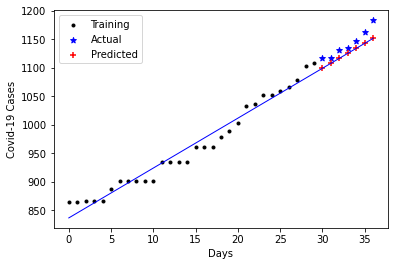

In [40]:
z = np.arange(days).reshape(-1,1)
training = plt.scatter(z, x_[i], color="black", marker='.', label='Training')
z_ = np.arange(days+DAYS_TO_PREDICT).reshape(-1,1)

plt.plot(z_, lr.predict(z_), color="blue", linewidth=1)
for j in range(DAYS_TO_PREDICT):
    actual = plt.scatter(30+j, y_[i][j], marker='*', label='Actual', color='blue')
    prediction = plt.scatter(30 + j, lr.predict(z_)[30+j], marker='+', label='Predicted', color='red')
plt.ylabel('Covid-19 Cases')
plt.xlabel('Days')
plt.legend([training, actual, prediction], ['Training', 'Actual', 'Predicted'])
# plt.xticks(())
# plt.yticks(())
plt.savefig('linear_regression_example.png')
_ = plt.show()

In [81]:
df = pd.DataFrame(summary_results)
df = df.T
df

,train,validate,test
Baseline 1,"{0: {'mae': 1717.3618469859337, 'rmse': 2152.4...","{0: {'mae': 1763.4056156062054, 'rmse': 2190.8...","{0: {'mae': 1681.0408622411487, 'rmse': 2134.5..."
Baseline 2,"{0: {'mae': 8.429402354856396, 'rmse': 68.8041...","{0: {'mae': 8.351147170865598, 'rmse': 67.2000...","{0: {'mae': 8.361327278551375, 'rmse': 69.5849..."
Baseline 3,"{0: {'mae': 113.34337381354005, 'rmse': 191.11...","{0: {'mae': 112.74494491526222, 'rmse': 190.26...","{0: {'mae': 112.0805320146442, 'rmse': 191.100..."
Baseline 4,"{0: {'mae': 30.205387826227913, 'rmse': 112.48...","{0: {'mae': 28.305218399690762, 'rmse': 110.42...","{0: {'mae': 30.226766041747197, 'rmse': 114.16..."


In [99]:
baselines_mae = [[] for i in range(4)]
baselines_rmse = [[] for i in range(4)]
for i, baseline in enumerate(summary_results.values()):
    for _, days in baseline.items():
        mae = {}
        rmse = {}
        for k, v in days.items():
            mae[k] = v['mae']
            rmse[k] = v['rmse']
        baselines_mae[i].append(mae)
        baselines_rmse[i].append(rmse)


In [109]:
mae_df = pd.DataFrame({'Baseline 1': baselines_mae[0][2], 'Baseline 2': baselines_mae[1][2], 'Baseline 3': baselines_mae[2][2], 'Baseline 4': baselines_mae[3][2]}).T
mae_df.columns = ([i for i in range(1,8)])
mae_df

,1,2,3,4,5,6,7
Baseline 1,1681.040862,1687.723303,1694.311070,1700.827258,1707.191656,1713.406207,1719.388321
Baseline 2,8.361327,16.819736,25.499290,34.341237,43.431795,52.751182,62.356436
Baseline 3,112.080532,120.355512,128.787247,137.362135,146.127162,155.080532,164.262730
Baseline 4,30.226766,36.039851,42.255847,48.501222,55.241510,62.529851,70.060823


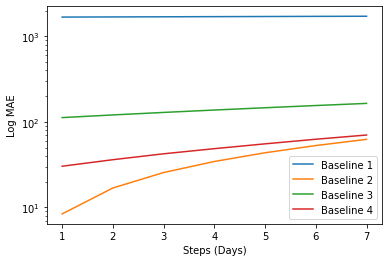

In [165]:
ax = mae_df.T.plot(kind='line',
                 # title='Mean Absolute Loss (Validation Set)',
                 logy=True,
                 xlabel='Steps (Days)',
                 ylabel='Log MAE')
fig = ax.get_figure()
fig.savefig('mae_validation.png')

In [132]:
rmse_df = pd.DataFrame({'Baseline 1': baselines_rmse[0][2], 'Baseline 2': baselines_rmse[1][2], 'Baseline 3': baselines_rmse[2][2], 'Baseline 4': baselines_rmse[3][2]}).T
rmse_df.columns = ([i for i in range(1,8)])
rmse_df

,1,2,3,4,5,6,7
Baseline 1,2134.566306,2141.398481,2148.153605,2154.852786,2161.401065,2167.827415,2174.014953
Baseline 2,69.584928,103.933481,133.397876,159.179092,184.564807,209.638514,235.068486
Baseline 3,191.100687,209.237790,227.467214,245.590994,264.114127,282.953669,302.420411
Baseline 4,114.163325,143.289731,173.189422,196.729050,222.033736,248.388797,273.838422


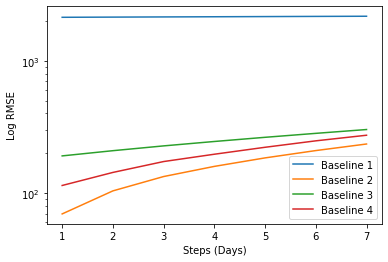

In [166]:
ax = rmse_df.T.plot(kind='line',
                 # title='Root Mean Square Loss (Validation Set)',
                 logy=True,
                 xlabel='Steps (Days)',
                 ylabel='Log RMSE')
fig = ax.get_figure()
fig.savefig('rmse_validation.png')

In [134]:
both_df = pd.DataFrame({'Baseline 1': {'mse': 1, 'rmse': baselines_rmse[0][2]}, 'Baseline 2': baselines_rmse[1][2], 'Baseline 3': baselines_rmse[2][2], 'Baseline 4': baselines_rmse[3][2]}).T
# both_df.columns = ([i for i in range(1,8)])
both_df

,mse,rmse,0,1,2,3,4,5,6
Baseline 1,1,"{0: 2134.5663057078123, 1: 2141.398480881179, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
Baseline 2,NaN,NaN,69.584928,103.933481,133.397876,159.179092,184.564807,209.638514,235.068486
Baseline 3,NaN,NaN,191.100687,209.23779,227.467214,245.590994,264.114127,282.953669,302.420411
Baseline 4,NaN,NaN,114.163325,143.289731,173.189422,196.72905,222.033736,248.388797,273.838422


In [151]:
sr = {}
for k,v in summary_results.items():
    for k_, v_ in v.items():
        if k_ == 'test':
            sr[k] = v_



combined_df = pd.DataFrame.from_dict({(i,j): sr[i][j] 
                           for i in sr.keys() 
                           for j in sr[i].keys()},
                       orient='index')
combined_df.columns = ['MAE', 'RMSE']
combined_df

MAE         RMSE
Baseline 1 0  1681.040862  2134.566306
           1  1687.723303  2141.398481
           2  1694.311070  2148.153605
           3  1700.827258  2154.852786
           4  1707.191656  2161.401065
           5  1713.406207  2167.827415
           6  1719.388321  2174.014953
Baseline 2 0     8.361327    69.584928
           1    16.819736   103.933481
           2    25.499290   133.397876
           3    34.341237   159.179092
           4    43.431795   184.564807
           5    52.751182   209.638514
           6    62.356436   235.068486
Baseline 3 0   112.080532   191.100687
           1   120.355512   209.237790
           2   128.787247   227.467214
           3   137.362135   245.590994
           4   146.127162   264.114127
           5   155.080532   282.953669
           6   164.262730   302.420411
Baseline 4 0    30.226766   114.163325
           1    36.039851   143.289731
           2    42.255847   173.189422
           3    48.501222   196.729050
           4    55.241510   222.033736
           5    62.529851   248.388797
           6    70.060823   273.838422

In [152]:
sr

{'Baseline 1': {0: {'mae': 1681.0408622411487, 'rmse': 2134.5663057078123}, 1: {'mae': 1687.7233027453788, 'rmse': 2141.398480881179}, 2: {'mae': 1694.311070075936, 'rmse': 2148.1536053043465}, 3: {'mae': 1700.827257824424, 'rmse': 2154.852786355121}, 4: {'mae': 1707.1916564602136, 'rmse': 2161.401065369048}, 5: {'mae': 1713.4062067795971, 'rmse': 2167.8274150411007}, 6: {'mae': 1719.388321305421, 'rmse': 2174.0149533436165}},
 'Baseline 2': {0: {'mae': 8.361327278551375, 'rmse': 69.5849279094092}, 1: {'mae': 16.819735825592133, 'rmse': 103.93348088952143}, 2: {'mae': 25.49928963087185, 'rmse': 133.3978759184048}, 3: {'mae': 34.34123721052929, 'rmse': 159.17909200571256}, 4: {'mae': 43.431795142356464, 'rmse': 184.56480663129327}, 5: {'mae': 52.75118237832338, 'rmse': 209.6385137470729}, 6: {'mae': 62.35643571818884, 'rmse': 235.0684859375391}},
 'Baseline 3': {0: {'mae': 112.0805320146442, 'rmse': 191.10068672107312}, 1: {'mae': 120.35551247426044, 'rmse': 209.2377902783539}, 2: {'mae

In [164]:
sr = {}
for k,v in summary_results.items():
    for k_, v_ in v.items():
        if k_ == 'test':
            sr[k] = v_
            
sr2 = defaultdict(dict)
for bl, days in sr.items():
    for day, values in days.items():
        for typ, value in values.items():
            sr2[(f'Step {day}', typ.upper())][bl] = value
sr2




combined_df = pd.DataFrame.from_dict(sr2)
pd.set_option('display.colheader_justify', 'center')
print(combined_df.style.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrr}
 & \multicolumn{2}{r}{Step 0} & \multicolumn{2}{r}{Step 1} & \multicolumn{2}{r}{Step 2} & \multicolumn{2}{r}{Step 3} & \multicolumn{2}{r}{Step 4} & \multicolumn{2}{r}{Step 5} & \multicolumn{2}{r}{Step 6} \\
 & MAE & RMSE & MAE & RMSE & MAE & RMSE & MAE & RMSE & MAE & RMSE & MAE & RMSE & MAE & RMSE \\
Baseline 1 & 1681.040862 & 2134.566306 & 1687.723303 & 2141.398481 & 1694.311070 & 2148.153605 & 1700.827258 & 2154.852786 & 1707.191656 & 2161.401065 & 1713.406207 & 2167.827415 & 1719.388321 & 2174.014953 \\
Baseline 2 & 8.361327 & 69.584928 & 16.819736 & 103.933481 & 25.499290 & 133.397876 & 34.341237 & 159.179092 & 43.431795 & 184.564807 & 52.751182 & 209.638514 & 62.356436 & 235.068486 \\
Baseline 3 & 112.080532 & 191.100687 & 120.355512 & 209.237790 & 128.787247 & 227.467214 & 137.362135 & 245.590994 & 146.127162 & 264.114127 & 155.080532 & 282.953669 & 164.262730 & 302.420411 \\
Baseline 4 & 30.226766 & 114.163325 & 36.039851 & 143.289731 & 42.255847

In [153]:
{(i,j): sr[i][j] 
                           for i in sr.keys() 
                           for j in sr[i].keys()}

{('Baseline 1', 0): {'mae': 1681.0408622411487, 'rmse': 2134.5663057078123},
 ('Baseline 1', 1): {'mae': 1687.7233027453788, 'rmse': 2141.398480881179},
 ('Baseline 1', 2): {'mae': 1694.311070075936, 'rmse': 2148.1536053043465},
 ('Baseline 1', 3): {'mae': 1700.827257824424, 'rmse': 2154.852786355121},
 ('Baseline 1', 4): {'mae': 1707.1916564602136, 'rmse': 2161.401065369048},
 ('Baseline 1', 5): {'mae': 1713.4062067795971, 'rmse': 2167.8274150411007},
 ('Baseline 1', 6): {'mae': 1719.388321305421, 'rmse': 2174.0149533436165},
 ('Baseline 2', 0): {'mae': 8.361327278551375, 'rmse': 69.5849279094092},
 ('Baseline 2', 1): {'mae': 16.819735825592133, 'rmse': 103.93348088952143},
 ('Baseline 2', 2): {'mae': 25.49928963087185, 'rmse': 133.3978759184048},
 ('Baseline 2', 3): {'mae': 34.34123721052929, 'rmse': 159.17909200571256},
 ('Baseline 2', 4): {'mae': 43.431795142356464, 'rmse': 184.56480663129327},
 ('Baseline 2', 5): {'mae': 52.75118237832338, 'rmse': 209.6385137470729},
 ('Baseline 2

In [154]:
sr

{'Baseline 1': {0: {'mae': 1681.0408622411487, 'rmse': 2134.5663057078123}, 1: {'mae': 1687.7233027453788, 'rmse': 2141.398480881179}, 2: {'mae': 1694.311070075936, 'rmse': 2148.1536053043465}, 3: {'mae': 1700.827257824424, 'rmse': 2154.852786355121}, 4: {'mae': 1707.1916564602136, 'rmse': 2161.401065369048}, 5: {'mae': 1713.4062067795971, 'rmse': 2167.8274150411007}, 6: {'mae': 1719.388321305421, 'rmse': 2174.0149533436165}},
 'Baseline 2': {0: {'mae': 8.361327278551375, 'rmse': 69.5849279094092}, 1: {'mae': 16.819735825592133, 'rmse': 103.93348088952143}, 2: {'mae': 25.49928963087185, 'rmse': 133.3978759184048}, 3: {'mae': 34.34123721052929, 'rmse': 159.17909200571256}, 4: {'mae': 43.431795142356464, 'rmse': 184.56480663129327}, 5: {'mae': 52.75118237832338, 'rmse': 209.6385137470729}, 6: {'mae': 62.35643571818884, 'rmse': 235.0684859375391}},
 'Baseline 3': {0: {'mae': 112.0805320146442, 'rmse': 191.10068672107312}, 1: {'mae': 120.35551247426044, 'rmse': 209.2377902783539}, 2: {'mae

In [155]:
sr2 = defaultdict(dict)
for bl, days in sr.items():
    for day, values in days.items():
        for typ, value in values.items():
            sr2[(typ, day)][bl] = value
sr2
            

defaultdict(dict,
            {('mae', 0): {'Baseline 1': 1681.0408622411487,
              'Baseline 2': 8.361327278551375,
              'Baseline 3': 112.0805320146442,
              'Baseline 4': 30.226766041747197},
             ('rmse', 0): {'Baseline 1': 2134.5663057078123,
              'Baseline 2': 69.5849279094092,
              'Baseline 3': 191.10068672107312,
              'Baseline 4': 114.1633250455933},
             ('mae', 1): {'Baseline 1': 1687.7233027453788,
              'Baseline 2': 16.819735825592133,
              'Baseline 3': 120.35551247426044,
              'Baseline 4': 36.039850695786626},
             ('rmse', 1): {'Baseline 1': 2141.398480881179,
              'Baseline 2': 103.93348088952143,
              'Baseline 3': 209.2377902783539,
              'Baseline 4': 143.28973138441035},
             ('mae', 2): {'Baseline 1': 1694.311070075936,
              'Baseline 2': 25.49928963087185,
              'Baseline 3': 128.78724676464043,
             

In [30]:
lr.predict(np.array([30]).reshape(-1,1))

array([[333.62068966]])

In [17]:
for name, ds in get_new_loop():
    for i, (x, y) in enumerate(ds):
        print(x.shape)
        break
    print(name, '-', i)

(995, 30, 101)
train - 0
(995, 30, 101)
validate - 0
(995, 30, 101)
test - 0


In [16]:
x_.shape
x_ = np.mean(x_, axis=1).flatten()
x_ = x_.reshape(-1,1)
x_ = x_ = np.repeat(x_, DAYS_TO_PREDICT, axis=1)
x_.shape

(995, 7)

In [18]:
!pip freeze|grep pandas

pandas==1.4.0


In [ ]:
for name, ds in get_new_loop():
    errors = np.zeros(DAYS_TO_PREDICT)
    count = 0
    for x, y in ds:
        print(x.shape, y.shape)
        print(x[0][-1][0])
        print(y[0][0][0])
        return
        print('breaking')
        break
        
        

In [185]:
train mae for day 0: 9.840150955581118
validate mae for day 0: 9.792210488958693
test mae for day 0: 9.854986715908877

array([1759., 1759., 1759., 1759., 1759., 1759., 1759.], dtype=float32)

In [184]:
y_[0]

array([1759., 1848., 1848., 1873., 1873., 1873., 1972.], dtype=float32)

In [179]:
x_

array([[1759., 1759., 1759., ..., 1759., 1759., 1759.],
       [1131., 1131., 1131., ..., 1131., 1131., 1131.],
       [1733., 1733., 1733., ..., 1733., 1733., 1733.],
       ...,
       [ 961.,  961.,  961., ...,  961.,  961.,  961.],
       [ 515.,  515.,  515., ...,  515.,  515.,  515.],
       [1282., 1282., 1282., ..., 1282., 1282., 1282.]], dtype=float32)

In [112]:
x = x_[0]
z = np.arange(x.shape[0]).reshape(-1,1)
y = y_[0]
# z = np.expand_dims(z,1)
lr = LinearRegression()
lr.fit(z,x)
np.abs(y - lr.predict(np.array([31]).reshape(-1,1))[0][0])

6.5670003707823525

In [104]:
z

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29]])

In [91]:
z = np.arange(x.shape[0])
z = np.expand_dims(z,1)
print(z.shape)
x = np.concatenate((z, x), axis=1)

(30, 1)


array([[  0., 488.],
       [  1., 491.],
       [  2., 492.],
       [  3., 498.],
       [  4., 500.],
       [  5., 515.],
       [  6., 530.],
       [  7., 530.],
       [  8., 531.],
       [  9., 532.],
       [ 10., 538.],
       [ 11., 548.],
       [ 12., 553.],
       [ 13., 569.],
       [ 14., 578.],
       [ 15., 579.],
       [ 16., 579.],
       [ 17., 582.],
       [ 18., 591.],
       [ 19., 595.],
       [ 20., 606.],
       [ 21., 633.],
       [ 22., 638.],
       [ 23., 640.],
       [ 24., 651.],
       [ 25., 662.],
       [ 26., 672.],
       [ 27., 687.],
       [ 28., 687.],
       [ 29., 692.]])

In [95]:
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)

reg.coef_

reg.intercept_

reg.predict(np.array([[3, 5]]))

array([16.])

In [97]:
y.shape

(4,)